# Numerical Methods for PDEs

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as spi
import scipy.signal as sps

## Numerical Integration

The function `scipy.integrate.quad` approximates a definite integral using the FORTRAN library QUADPACK (see the [documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.quad.html)).

In [2]:
f = lambda x: 1/(1 + x**2)
a = 0
b = 1
I,error = spi.quad(f,a,b)

In [3]:
I

0.7853981633974484

In [4]:
error

8.719671245021581e-15

In [5]:
np.pi/4

0.7853981633974483

## Fourier Series

Let $f(x)$ be a $2L$-periodic function. The **Fourier series** of $f(x)$ is 

$$
f(x) = \frac{a_0}{2} + \sum_{n=1}^{\infty} a_n \cos \left( \frac{n \pi x}{L} \right) + \sum_{n=1}^{\infty} b_n \sin \left( \frac{n \pi x}{L} \right)
$$

where the Fourier coefficients are given by the integral formulas
$$
a_0 = \frac{1}{L} \int_{-L}^L f(x) dx
$$

$$
a_n = \frac{1}{L} \int_{-L}^L f(x) \cos \left( \frac{n \pi x}{L} \right) dx
$$

$$
b_n = \frac{1}{L} \int_{-L}^L f(x) \sin \left( \frac{n \pi x}{L} \right) dx
$$

Write a function called `fourier` which takes `f`, `L` and `N` and returns a tuple `(a0,a,b)` where `a0` is the Fourier coefficient $a_0$ and  `a` and `b` are NumPy arrays of coefficients $a_1,\dots,a_N$ and $b_1,\dots,b_N$ respectively. Note that Python uses 0-indexing therefore `a[n-1]` corresponds to $a_n$ and `b[n-1]` corresponds to $b_n$.

In [6]:
def fourier(f,L,N):
    I,_ = spi.quad(f,-L,L)
    a0 = 1/L*I
    a = np.zeros(N)
    b = np.zeros(N)
    for n in range(1,N+1):
        integrand = lambda x: f(x)*np.cos(n*np.pi*x/L)
        I,_ = spi.quad(integrand,-L,L)
        a[n-1] = 1/L*I
        integrand = lambda x: f(x)*np.sin(n*np.pi*x/L)
        I,_ = spi.quad(integrand,-L,L)
        b[n-1] = 1/L*I
    return (a0,a,b)

In [7]:
L = 1
f = lambda x: 1 + np.cos(2*np.pi*x/L) + np.sin(np.pi*x/L)
N = 2
a0,a,b = fourier(f,L,N) # a0 = 2, a = [0,1], b = [1,0]

In [8]:
a0

2.0

In [9]:
a

array([2.5475719e-17, 1.0000000e+00])

In [10]:
b

array([1.00000000e+00, 2.53445221e-17])

In [11]:
L = np.pi
a0,a,b = fourier(sps.square,L,5)

In [12]:
a0

0.0

In [13]:
a

array([0., 0., 0., 0., 0.])

In [14]:
b

array([1.27323954e+00, 1.08995295e-16, 4.24413182e-01, 7.91317321e-17,
       2.54647909e-01])

Write a function called `fouriersum` which takes `a0`, `a`, `b`, `x` and `L` and returns the corresponding values of the partial Fourier sum

$$
f(x) = \frac{a_0}{2} + \sum_{n=1}^{|a|} a_n \cos \left( \frac{n \pi x}{L} \right) + \sum_{n=1}^{|b|} b_n \sin \left( \frac{n \pi x}{L} \right)
$$

In [15]:
def fouriersum(a0,a,b,x,L):
    cosine_sum = sum([a[n-1]*np.cos(n*np.pi*x/L) for n in range(1,len(a)+1)])
    sine_sum = sum([b[n-1]*np.sin(n*np.pi*x/L) for n in range(1,len(b)+1)])
    return a0/2 + cosine_sum + sine_sum

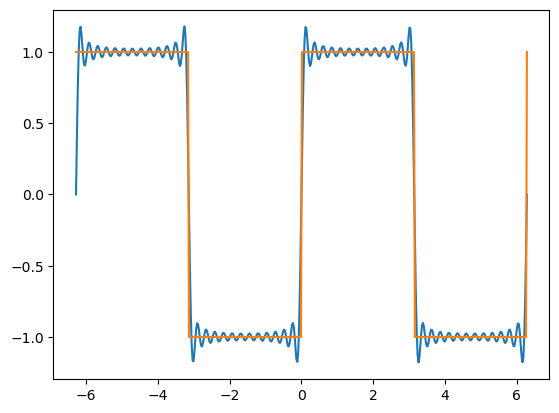

In [16]:
L = 2*np.pi
a0,a,b = fourier(sps.square,L,50)
x = np.linspace(-L,L,500)
y = fouriersum(a0,a,b,x,L)
plt.plot(x,y,x,sps.square(x))
plt.show()

## Heat Equation

Let $u(x,t)$ denote the temperature of a uniform bar of length $L$ at position $x$ and time $t$. The 1D heat equation with initial/boundary conditions is

$$
u_t = \alpha u_{xx} \ \ , \ \alpha > 0 \ \ , \ u(0,t) = G_0(t) \ \ , \ u(L,t) = G_L(t) \ \ , \ u(x,0) = F(x)
$$

### Discretization

Choose a step size $h$ in the $x$ direction and $k$ in the $t$ direction and create a grid of points:

\begin{align}
x_i &= ih \ , \ \ i = 0,1, \dots, N \ , \ \ h = \frac{L}{N} \\
t_j &= jk \ , \ \ j = 0,1, \dots, M \ , \ \ k=\frac{t_f}{M}
\end{align}

The goal of a finite difference method is to compute the $(N+1) \times (M+1)$ matrix

$$
U = [u_{i,j}]
$$

which gives approximations of the solution $u(x,t)$ at the grid points:

$$
u_{i,j} \approx u(x_i,t_j) = u(ih,jk)
$$

where $x_0 = 0$, $x_N = L$, $t_0 = 0$ and $t_M = t_f$.

### Forward Time Central Space (FTCS) Method

Apply the forward difference formula for $u_t$ at position $x_i$ and time $t_j$

\begin{align*}
u_t(x_i,t_j) &= \frac{u(x_i,t_{j+1}) - u(x_i,t_j)}{k} + O(k) \\
&= \frac{u_{i,j+1} - u_{i,j}}{k} + O(k)
\end{align*}

Apply the central difference formula for $u_{xx}$ at position $x_i$ and time $t_j$

\begin{align*}
u_{xx}(x_i,t_j) &= \frac{u(x_{i+1},t_j) - 2u(x_i,t_j) + u(x_{i-1},t_j)}{h^2} + O(h^2) \\
&= \frac{u_{i+1,j} - 2u_{i,j} + u_{i-1,j}}{h^2} + O(h^2)
\end{align*}

Plug the formulas into the heat equation at position $x_i$ and time $t_j$

\begin{align*}
u_t(x_i,t_j) &= \alpha u_{xx}(x_i,t_j) \\
\frac{u_{i,j+1} - u_{i,j}}{k}
&=
\alpha \left( \frac{u_{i+1,j} - 2u_{i,j} + u_{i-1,j}}{h^2} \right)
\end{align*}

Rearrange to solve for $u_{i,j+1}$

\begin{equation}
u_{i,j+1} = r u_{i-1,j} + (1 - 2r) u_{i,j} + r u_{i+1,j} \ \ , \ \ r = \frac{\alpha k}{h^2}
\end{equation}

Write out the equations for fixed $j$ and note that we know the boundary values

\begin{align*}
u_{0,j} &= u(0,t_j) = G_0(t_j) \\
u_{N,j} &= u(L,t_j) = G_L(t_j)
\end{align*}

$$
\begin{array}{cccccccccccccc}
u_{1,j+1} & = & (1 - 2r) u_{1,j}  & + & \, ru_{2,j}  &  & &  & & & & + & r \, G_0(t_j) \\
u_{2,j+1} & = & r \, u_{1,j} & +  & (1 - 2r) u_{2,j}  & +  & r \, u_{3,j} & & & & & & \\
%u_{3,j+1} & = & & & r \, u_{2,j}  & +  & (1 - 2r) u_{3,j}  & + & r \, u_{4,j} & & & &  \\
 & \vdots &  & &  & &  &  & & &  & & \\
u_{N-2,j+1} & = & & & & & r \, u_{N-3,j}  & +  & (1 - 2r) u_{N-2,j}  & +  & r u_{N-1,j} & & \\
u_{N-1,j+1} & = & & & & & & & r \, u_{N-2,j}  & +  & (1 - 2r) u_{N-1,j}  & +  & r \, G_L(t_j)
\end{array}
$$

The **forward time central space (FTCS) method** for the heat equation is given by the iterative matrix formula

$$
\boldsymbol{u}_{j+1} = A \boldsymbol{u}_j + \boldsymbol{g}_j
$$

where $A$ is the $(N-1) \times (N-1)$ matrix

$$
A = 
\left[
\begin{array}{ccccc}
1 - 2r & r & & & \\
r & 1 - 2r & r & & \\
& & \ddots & & \\
& & r & 1 - 2r & r \\
& & & r & 1 - 2r \\
\end{array}
\right]
$$

$$
\boldsymbol{u}_j = \begin{bmatrix} u_{1,j} \\ u_{2,j} \\ \vdots \\ u_{N-2,j} \\ u_{N-1,j} \end{bmatrix}
\ \ \ \ \
\boldsymbol{g}_j =
\begin{bmatrix} r G_0(t_j) \\ 0 \\ \vdots \\ 0 \\ r G_L(t_j) \end{bmatrix}
\ \ \ \ \
r = \frac{\alpha k}{h^2}
$$

with the initial condition

$$
\boldsymbol{u}_0 = \begin{bmatrix} u_{1,0} \\ u_{2,0} \\ \vdots \\ u_{N-1,0} \end{bmatrix}
= \begin{bmatrix} F(x_1) \\ F(x_2) \\ \vdots \\ F(x_{N-1}) \end{bmatrix}
$$

The FTCS method is **numerically stable** for

$$
r = \frac{\alpha k}{h^2} < \frac{1}{2}
$$

Choose values to determine $r$:

In [17]:
alpha = 0.02
L = 1
tf = 5
N = 50
M = 1000
h = L/N
k = tf/M
r = alpha*k/h**2
r

0.25

Create matrix $A$:

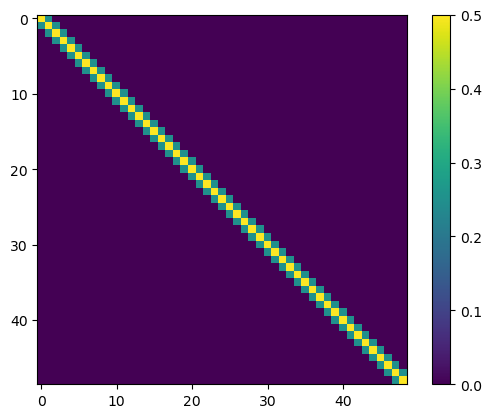

In [18]:
A = (1 - 2*r)*np.eye(N-1) + r*np.diag(np.ones(N-2),1) + r*np.diag(np.ones(N-2),-1)
plt.imshow(A), plt.colorbar()
plt.show()

Define initial and boundary conditions:

In [19]:
F = lambda x: sps.square(3*np.pi*x/L)
G0 = lambda t: np.sin(3*t)
GL = lambda t: np.cos(2*t)

Initialize matrix $U$:

In [20]:
x = np.linspace(0,L,N+1)
t = np.linspace(0,tf,M+1)
U = np.zeros((N+1,M+1))
U[0,:] = G0(t)
U[-1,:] = GL(t)
U[1:-1,0] = F(x[1:-1])

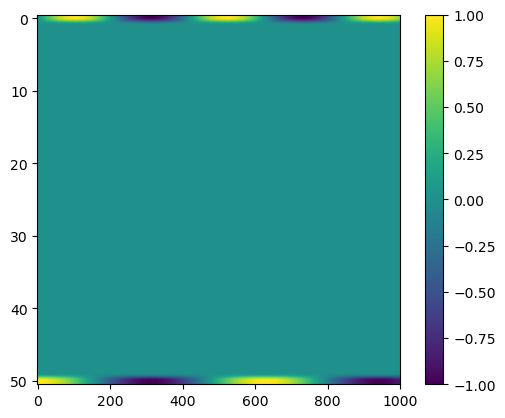

In [21]:
plt.imshow(U,aspect=20), plt.colorbar()
plt.show()

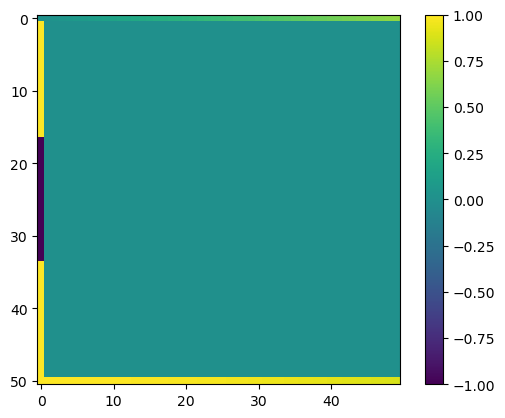

In [22]:
plt.imshow(U[:,:50]), plt.colorbar()
plt.show()

Implement iterative method:

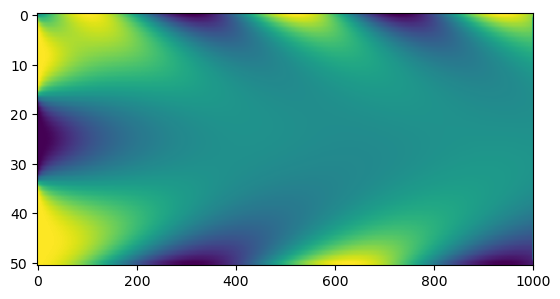

In [23]:
for j in range(0,M-1):
    gj = np.zeros(N-1)
    gj[0] = r*G0(t[j])
    gj[-1] = r*GL(t[j])
    U[1:-1:,j+1] = A@U[1:-1:,j] + gj
plt.imshow(U,aspect=10)
plt.show()